### Importing and installing required libraries

In [ ]:
!pip install -q pyLDAvis jsonlines ipywidgets langchain-community pypdf langchain-google-genai wget pdfplumber gradio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.7/298.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [ ]:
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

#warning
import warnings
warnings.filterwarnings('ignore')

#dropdown menu
import ipywidgets as widgets
from IPython.display import display

#pdf to text
from langchain.document_loaders import PyPDFLoader

#for skill extraction
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
import os
import wget

#user interface
import pdfplumber
import gradio as gr
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from google.colab import userdata


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Dataset

A collection of 2400+ Resume Examples for categorizing a given resume into any of the labels defined in the dataset: [Resume Dataset.](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset?resource=download-directory)

Download the dataset from the provided link and upload it to [Google Drive](https://drive.google.com/drive/quota).

In [ ]:
!wget -q --no-check-certificate "https://drive.google.com/uc?id=1UNEKzxoU831tkbF2R-YawrzBrWdz4vFM" -O /content/Resume.csv

In [ ]:
df = pd.read_csv("/content/Resume.csv")
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[
    0:200,
]
data.head()

,ID,Resume_str,Resume_html,Category
2014,22894544,DRIVER/MANAGER Professional S...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
710,13352113,LICENSED UNITED HEALTHCARE INSURANCE ...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
1782,19553067,PROJECT ADMINISTRATOR \tENGINEERING ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING
1313,14556869,DIGITAL MARKETING INTERN Educat...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA
247,11580408,INFORMATION TECHNOLOGY COORDINATOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY


In [ ]:
data.shape

(200, 4)

### Loading spaCy model

In [ ]:
!python -m spacy download en_core_web_lg -q
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 111.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Entity Ruler

The [jobzilla skill dataset](https://drive.google.com/uc?export=download&id=1e50jVIFfmM9lYdEVE0wJrHaEn9Dd1QE8
) is jsonl file containing different skills that can be used to create spaCy entity_ruler. The data set contains label and pattern-> diferent words used to descibe skills in various resume.

Download the dataset from the provided link and upload it to [Google Drive](https://drive.google.com/drive/quota).

In [ ]:
!wget -q --no-check-certificate "https://drive.google.com/uc?id=1e50jVIFfmM9lYdEVE0wJrHaEn9Dd1QE8" -O /content/jz_skill_patterns.jsonl

In [ ]:
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "/content/jz_skill_patterns.jsonl"

In [ ]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

### Skills
We will create two python functions to extract all the skills within a resume and create an array containing all the skills. Later we are going to apply this function to our dataset and create a new feature called skill.



*   **get_skills** is going to extract skills from a single text.
*   **unique_skills** will remove duplicates.



In [ ]:
import re
url_pattern = r'(https?://\S+|www\.\S+)'
special_characters = r'[^A-Za-z0-9\s]'

### Cleaning Resume Text


*   We are going to use regex to remove hyperlinks, special characters, or punctuations.
*   Lowering text
*   Splitting text into array based on space
*   Lemmatizing text to its base form for normalizations
*   Removing English stopwords
*   Appending the results into an array.

In [ ]:
def get_skills(text):
    text = re.sub(url_pattern, '', text)
    text = re.sub(special_characters, '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return list(set(subset))

def unique_skills(x):
    return list(set(x))

In [ ]:
clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In this section, we are going to apply all the functions we have created previously

*  creating Clean_Resume columns and adding cleaning Resume data.
* creating skills columns, lowering text, and applying the get_skills function.
* removing duplicates from skills columns.

In [ ]:
#cleaning the dataset
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
2014,22894544,DRIVER/MANAGER Professional S...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,driver manager professional summary 4 year tot...,"[schedule, business, material]"
710,13352113,LICENSED UNITED HEALTHCARE INSURANCE ...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,licensed united healthcare insurance sale agen...,"[amp, certificate, collaboration, simulation, ..."
1782,19553067,PROJECT ADMINISTRATOR \tENGINEERING ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,project administrator engineering summary cons...,"[engineering, certificate, monitoring, schedul..."
1313,14556869,DIGITAL MARKETING INTERN Educat...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,digital marketing intern education 2015 bachel...,"[marketing, database, adobe photoshop, design,..."
247,11580408,INFORMATION TECHNOLOGY COORDINATOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,information technology coordinator career over...,"[certificate, business process, server, mobile..."


In [ ]:
#checking the get_skills function on the dataset
get_skills(data['Clean_Resume'].iloc[0])

['schedule', 'business', 'material']

# Visualization

### Jobs Distribution
As we can see our random 200 samples contain a variety of job categories.

In [ ]:
#plotting the variation of job categories
fig = px.histogram(
    data, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

Dropdwon function for selecting a job category.

In [ ]:
Job_Category = None

dropdown = widgets.Dropdown(
    options=[
        'ENGINEERING', 'BANKING', 'AGRICULTURE', 'PUBLIC-RELATIONS', 'ALL',
        'HEALTHCARE', 'CONSULTANT', 'SALES', 'CHEF', 'DIGITAL-MEDIA',
        'ACCOUNTANT', 'AUTOMOBILE', 'APPAREL', 'INFORMATION-TECHNOLOGY', 'BPO',
        'BUSINESS-DEVELOPMENT', 'AVIATION', 'CONSTRUCTION', 'DESIGNER',
        'ADVOCATE', 'TEACHER', 'ARTS', 'FITNESS', 'HR', 'FINANCE'
    ],
    value='ENGINEERING',
    description='Choose:',
    disabled=False,
)

submit_button = widgets.Button(description="Submit")

def on_change(change):
    global Job_Category
    Job_Category = change['new']
    print(f"You selected: {Job_Category}")

dropdown.observe(on_change, names='value')

def on_button_click(change):
    global Job_Category
    Job_Category = dropdown.value
    print(f"Job category stored: {Job_Category}")

submit_button.on_click(on_button_click)

display(dropdown, submit_button)



Dropdown(description='Choose:', options=('ENGINEERING', 'BANKING', 'AGRICULTURE', 'PUBLIC-RELATIONS', 'ALL', '…

Button(description='Submit', style=ButtonStyle())

Job category stored: ENGINEERING


### Skills
In this part, we are going to use the input cell to create category variables and then visualize the distribution of skills based on selected Job Descriptions.

In [ ]:
#checking the stored job category
print(Job_Category)

ENGINEERING


In [ ]:
Total_skills = []
if Job_Category != "ALL":
    fltr = data[data["Category"] == Job_Category]["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)
else:
    fltr = data["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)

fig = px.histogram(
    x=Total_skills,
    labels={"x": "Skills"},
    title=f"{Job_Category} Distribution of Skills",
).update_xaxes(categoryorder="total descending")
fig.show()


### Most used words(Word Cloud)
In this part, we are going to display the most used words in the Resume filter by job category.

Text(0.5, 1.0, 'Most Used Words in ENGINEERING Resume')

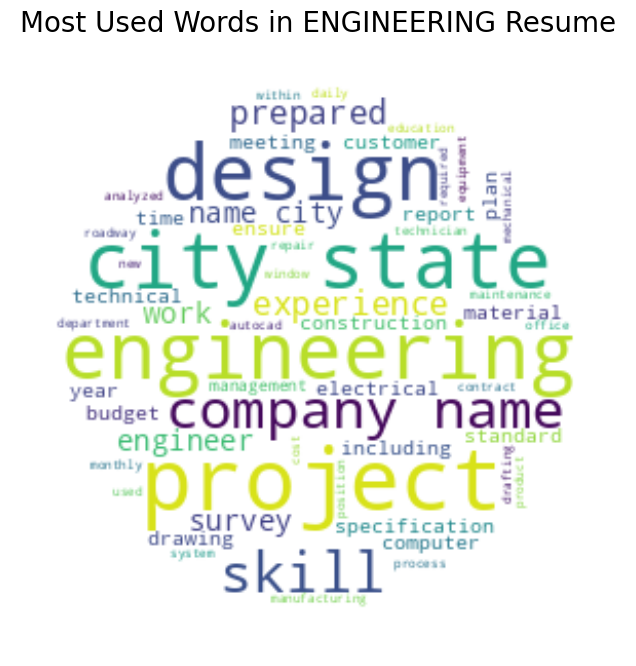

In [ ]:
text = ""
for i in data[data["Category"] == Job_Category]["Clean_Resume"].values:
    text += i + " "

plt.figure(figsize=(8, 8))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {Job_Category} Resume", fontsize=20)

### Entity Recognition
We can also display various entities within our raw text by using spaCy displacy.render.

In [ ]:
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

### Dependency Parsing
We can also visualize dependencies by just changing style to dep as shown below. We have also limited words to 10 which includes space too. Limiting the words will make it visualize the small chunk of data.

In [ ]:
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

### Custom Entity Recognition

* Adding Job-Category into entity ruler.
* Adding custom colors to all categories.
* Adding gradient colors to SKILL and Job-Category

In [ ]:
patterns = df.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label": "Job-Category", "pattern": a}])

In [ ]:
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

In [ ]:
# Load spaCy model
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "jz_skill_patterns.jsonl"

ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)

url_pattern = r'(https?://\S+|www\.\S+)'
special_characters = r'[^A-Za-z0-9\s]'

# Initialize the Gemini LLM
os.environ["GOOGLE_API_KEY"] = userdata.get('GEMINI_API')

llm = ChatGoogleGenerativeAI(
    model="gemini-pro",
    temperature=0.0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

# Function to extract skills using LLM
def llm_extraction(text):
    prompt = PromptTemplate(
        # Change: Adding input_variables to match the template
        input_variables=["resume_text"],
        template=f"""
        Extract the skills from the following resume text, including programming languages, frameworks, tools, and other relevant skills.
        Resume Text:
        {text}
        Output: **A single python list** containing all the skills and not a multiline string.
        """
    )
    llm_chain = LLMChain(prompt=prompt, llm=llm)
    return llm_chain.run({"resume_text": text})



In [ ]:
# Function to extract text from PDF
def extract_text_from_pdf(pdf_file):
    with pdfplumber.open(pdf_file) as pdf:
        return "\n".join([page.extract_text() for page in pdf.pages if page.extract_text()])


def category_skills(Job_Category):
  Total_skills = []
  if Job_Category != "ALL":
    fltr = data[data["Category"] == Job_Category]["skills"]
    for x in fltr:
      for i in x:
            Total_skills.append(i)
  else:
      fltr = data["skills"]
      for x in fltr:
        for i in x:
            Total_skills.append(i)
  return Total_skills

def analysis_skills(resume_skills,job_category):
  resume_skills = [skill.lower() for skill in resume_skills]
  resume_skills_str = ", ".join(resume_skills)
  prompt = PromptTemplate(
        input_variables=["skills", "category"],
        template="""
        Skills to classify: {skills}

    Task: Classify the following skills for the job category: {category}

    Instructions:
    1. Examine each skill carefully
    2. Classify each skill into exactly one of these categories:
       - Very_Relevant: Implies these are very relevant skills used by industry professionals extensively
       - Relevant: these skills are relevant to the category role directly
       - Somewhat_relevant: Not directly relevant but can be put to use in the role
       - Irrelevant: Skills not related to this job category

    3. Include every skill from the input list in exactly one category and try to have a even distribution in 4 categories

  Remember:
    - Every skill must be classified
    - Each skill should appear in exactly one category
    - Use double quotes for strings
    - Include all four categories even if some are empty

    the classified part should have the same number of skills as the number of skills provided

   give me output in proper format, in a **pleasing manner** for a user to understand.
    """
    )
  llm_chain = LLMChain(prompt=prompt, llm=llm)
  return llm_chain.run({
        "skills": resume_skills_str,
        "category" : job_category
    })

# Function to calculate skill match score
def calculate_matching_score(resume_skills, job_skills,job_category):
    resume_skills = [skill.lower() for skill in resume_skills]
    job_skills = [skill.lower() for skill in job_skills]
    resume_skills_str = ", ".join(resume_skills)  # ✅ Convert list to string
    job_skills_str = ", ".join(job_skills)
    prompt = PromptTemplate(
        input_variables=["resume_skills", "job_skills", "job_category"],
        template="""
        Given the following extracted skills from a resume and the required job skills for the {job_category} role,
        determine a **matching score** (in percentage) based on their relevancy and context.

        Extracted Resume Skills: {resume_skills}
        Required Job Skills: {job_skills}


        Output shoul be a **FLOAT** from 0 to 100 indicating the match level contextually.
        """
    )
    llm_chain = LLMChain(prompt=prompt, llm=llm)
    return llm_chain.run({
        "resume_skills": resume_skills_str,
        "job_skills": job_skills_str,
        "job_category": job_category
    })


def jaccard_similarity(list1, list2):
    """Calculate Jaccard Similarity between two sets"""
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

sbert_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')


def semantic_similarity(resume_skills, job_skills):
    """Compute pairwise semantic similarity between resume and job skills using SBERT."""
    if not resume_skills or not job_skills:
        return 0.0

    # Encode skills into dense vectors
    resume_vectors = sbert_model.encode(resume_skills, convert_to_tensor=True).cpu().numpy()
    job_vectors = sbert_model.encode(job_skills, convert_to_tensor=True).cpu().numpy()

    # Ensure 2D shape for cosine similarity
    if len(resume_vectors.shape) == 1:
        resume_vectors = np.expand_dims(resume_vectors, axis=0)  # Convert (384,) → (1, 384)
    if len(job_vectors.shape) == 1:
        job_vectors = np.expand_dims(job_vectors, axis=0)  # Convert (384,) → (1, 384)

    # Compute cosine similarity for all pairs
    similarity_matrix = cosine_similarity(resume_vectors, job_vectors)  # (num_resume_skills, num_job_skills)

    # Take the best matching job skill for each resume skill
    best_match_scores = similarity_matrix.max(axis=1)  # Best match for each resume skill

    return np.mean(best_match_scores) * 100

def tfidf_weighted_score(resume_skills, job_skills):
    """Calculate skill match using TF-IDF weights"""
    all_skills = list(set(resume_skills + job_skills))

    vectorizer = TfidfVectorizer()
    skill_matrix = vectorizer.fit_transform([" ".join(resume_skills), " ".join(job_skills)])

    similarity = cosine_similarity(skill_matrix)[0][1]
    return similarity

def calculate_final_score(resume_skills, job_skills):
    """Combining multiple scores to get a weighted final score"""

    jac_sim = jaccard_similarity(resume_skills, job_skills) * 100  # Jaccard Similarity Score
    cos_sim = semantic_similarity(resume_skills, job_skills)  # Word Embeddings
    tfidf_sim = tfidf_weighted_score(resume_skills, job_skills) * 100  # TF-IDF Weighted Score

    final_score = (0.2 * jac_sim) + (1.6 * cos_sim) + (0.2 * tfidf_sim)  # Weighted Combination
    return round(final_score, 2)



categories = ['ENGINEERING', 'BANKING', 'AGRICULTURE', 'PUBLIC-RELATIONS', 'ALL',
        'HEALTHCARE', 'CONSULTANT', 'SALES', 'CHEF', 'DIGITAL-MEDIA',
        'ACCOUNTANT', 'AUTOMOBILE', 'APPAREL', 'INFORMATION-TECHNOLOGY', 'BPO',
        'BUSINESS-DEVELOPMENT', 'AVIATION', 'CONSTRUCTION', 'DESIGNER',
        'ADVOCATE', 'TEACHER', 'ARTS', 'FITNESS', 'HR', 'FINANCE']

# Gradio Interface
def process_resume(pdf_file, job_category):
    resume_text = extract_text_from_pdf(pdf_file)
    extracted_skills_spacy = get_skills(resume_text)
    extracted_skills_llm = llm_extraction(resume_text)
    job_skills = category_skills(job_category)
    matching_score = calculate_matching_score(extracted_skills_llm, job_skills , job_category)
    maths_skill_score = calculate_final_score(list(extracted_skills_llm), job_skills)
    return extracted_skills_spacy, extracted_skills_llm , float(matching_score), analysis_skills(extracted_skills_llm, job_category), maths_skill_score

iface = gr.Interface(
    fn=process_resume,
    inputs=[gr.File(label="Upload Resume (PDF Only)"), gr.Dropdown(choices=categories, label="Select Job Category")],
    outputs=[gr.Textbox(label="Extracted Skills (spaCy)"), gr.Textbox(label="Extracted Skills (LLM)"), gr.Textbox(label="Matching Score"),gr.Textbox(label="Analysis"),gr.Textbox(label ="Score")],
    title="Resume Skill Extractor & Matcher",
    description="Upload a resume, select a job category, and input job skills to extract and match skills using spaCy and LLM."
)

if __name__ == "__main__":
    iface.launch()

if __name__ == "__main__":
    iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c302379a474a364e23.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
